# Tutorial V: Transfer Learning

<p>
Bern Winter School on Machine Learning, 2022<br>
Prepared by Mykhailo Vladymyrov.
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this session we will use the pretrained Inception model to build own image classifier. We will aslo learn how to save our trained models.

## 1. Load necessary libraries

In [1]:
colab = True # set to True is using google colab

In [2]:
if colab:
    %tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
import os
import sys
import shutil
import tarfile

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import tensorflow as tf
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import tag_constants

from PIL import Image

%load_ext tensorboard

#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Download libraries

In [4]:
if colab:
    path = os.path.abspath('.')+'/material.tgz'
    url = 'https://github.com/neworldemancer/BMLWS/raw/main/tut_files/tpub0320.tgz'
    p = tf.keras.utils.get_file(path, url)
    assert p==path
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()

81207979/81207979 [==============================] - 1s 0us/step


## 2. Transfer learning

We load first an inception model with pretrained weights, without the final classifier:
trained on the imagnet dataset (1000000 images, 1000 classes)

In [5]:
base_model = tf.keras.applications.InceptionV3(include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
#input: images with three color channels, of any size 
#tf.keras.utils.plot_model(base_model, show_shapes=True)

And build a new model using it:

In [6]:
x = tf.keras.layers.Input(shape=(256,256,3), dtype=tf.float32)

base_model.trainable = False
base_out = base_model(x)

base_out_f = tf.keras.layers.GlobalAveragePooling2D()(base_out)

h1 = tf.keras.layers.Dense(64, activation='sigmoid')(base_out_f)
h2 = tf.keras.layers.Dense(2, activation='softmax')(h1)

model = tf.keras.Model(x, h2)

model.compile(optimizer=tf.keras.optimizers.Adam(0.0005,) ,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 21,934,050
Trainable params: 131,266
Non-trainable params: 21,802,784
___________________________________________

## 3. Dataset

The Inception network is trained on natural images: thigs we see around everyday, like sky, flowers, animals, building, cars.
It builds an hierarchy of features, to describe what it sees. 
This features can be used to train fast on different classes of objects. E.g. [here](https://www.tensorflow.org/tutorials/image_retraining) are more examples on transfer learning.

Here you will see that these features can be even used to detect thngs very different from natural images. Namely we will try to use it to distinguish German text from Italian. We will use 100 samples, taken from 5 German and 5 Italian books, 10 samples each.

In [8]:
def prepare_training_img(img, crop=True, resize=True, img_size=(256, 256)):
    if img.dtype != np.uint8:
        img *= 255.0

    if crop:
        crop = np.min(img.shape[:2])
        r = (img.shape[0] - crop) // 2
        c = (img.shape[1] - crop) // 2
        cropped = img[r: r + crop, c: c + crop]
    else:
        cropped = img

    if resize:
        img_pil = Image.fromarray(cropped)
        img_pil = img_pil.resize(img_size, Image.ANTIALIAS)
        resized = np.array(img_pil.convert('RGB'))
    else:
        resized = cropped.copy()

    if resized.ndim == 2:
        resized = resized[..., np.newaxis]
    if resized.shape[2] == 4:
        resized = resized[..., :3]
    if resized.shape[2] == 1:
        resized = np.concatenate((resized, resized, resized), axis=2)

    resized = resized.astype(np.float32)

    img_preproc = tf.keras.applications.inception_v3.preprocess_input(resized)
    # subtract imagenet mean
    return img_preproc

def training_img_to_display(img):
  return (img+1)/2

In [9]:
text_label = ['German', 'Italian']

In [10]:
labels0 = []
images0 = []
labels1 = []
images1 = []

#German
for book in range(1,6):
    for sample in range(1,11):
        img = plt.imread('ML3/de/%d_%d.jpg'%(book, sample))
        assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
        images0.append(prepare_training_img(img))
        labels0.append([1,0])
for book in range(1,6):
    for sample in range(1,11):
        img = plt.imread('ML3/it/%d_%d.jpg'%(book, sample))
        assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
        images1.append(prepare_training_img(img))
        labels1.append([0,1])
        
idx = np.random.permutation(len(labels0))
labels0 = np.array(labels0)[idx]
images0 = np.array(images0)[idx]
labels1 = np.array(labels1)[idx]
images1 = np.array(images1)[idx]

In [17]:
print(y_train)

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]


In [13]:
#We will take 80% from each for training and 20 for validation
n_half = images0.shape[0]
n_train_half = n_half*80//100
n_train = n_train_half*2

x_train = np.concatenate([images0[:n_train_half], images1[:n_train_half]]) # 20% of each group to the testset
y_train = np.concatenate([labels0[:n_train_half], labels1[:n_train_half]])

x_valid = np.concatenate([images0[n_train_half:], images1[n_train_half:]])
y_valid = np.concatenate([labels0[n_train_half:], labels1[n_train_half:]])

Lets see a sample:

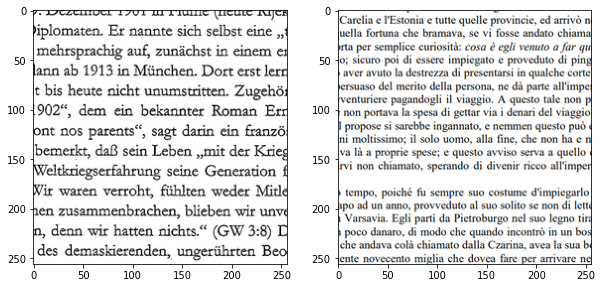

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(10,10))
img_d = training_img_to_display(images0[25])
axs[0].imshow(img_d)
axs[0].grid(False)
img_d = training_img_to_display(images1[25])
axs[1].imshow(img_d)
axs[1].grid(False)
plt.show()

## 4. Training

The training is similar to what we we saw previously.

Since Inception model is big, this will take a while, even we use GPUs. On your laptop CPU this would probably take ~15 times longer. And we are not training the whole Inception! We have just small thing on top + a very small dataset!

We will use callback to save checkpoints on each iteration of training. They contain values of trainable variables.

In [ ]:
save_path = 'save/text_{epoch}.ckpt'

batch_size=10
n_itr_per_epoch = len(x_train) // batch_size
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                   save_weights_only=True,
                                                   save_freq=1 * n_itr_per_epoch) # save every 1 epochs

hist = model.fit(x_train, y_train,
                 epochs=150, batch_size=batch_size, 
                 validation_data=(x_valid, y_valid),
                 callbacks=[save_callback])

Epoch 1/150
8/8 [==============================] - 13s 269ms/step - loss: 0.7024 - accuracy: 0.4500 - val_loss: 0.6362 - val_accuracy: 0.6000
Epoch 2/150
8/8 [==============================] - 1s 115ms/step - loss: 0.6614 - accuracy: 0.6000 - val_loss: 0.5720 - val_accuracy: 0.7500
Epoch 3/150
8/8 [==============================] - 1s 118ms/step - loss: 0.5597 - accuracy: 0.7000 - val_loss: 0.5826 - val_accuracy: 0.6500
Epoch 4/150
8/8 [==============================] - 1s 105ms/step - loss: 0.5361 - accuracy: 0.8000 - val_loss: 0.5555 - val_accuracy: 0.7000
Epoch 5/150
8/8 [==============================] - 1s 111ms/step - loss: 0.4801 - accuracy: 0.8500 - val_loss: 0.5599 - val_accuracy: 0.7000
Epoch 6/150
8/8 [==============================] - 1s 119ms/step - loss: 0.4484 - accuracy: 0.8375 - val_loss: 0.5259 - val_accuracy: 0.7500
Epoch 7/150
8/8 [==============================] - 1s 103ms/step - loss: 0.4242 - accuracy: 0.9250 - val_loss: 0.5233 - val_accuracy: 0.6500
Epoch 8/150


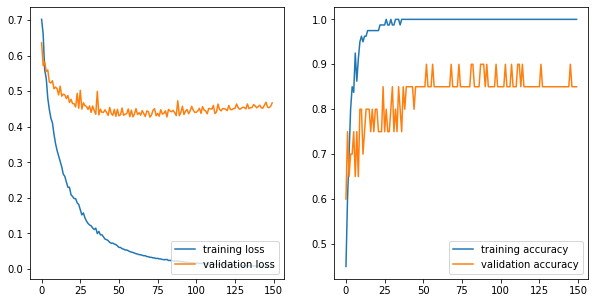

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

We see that training accuracy hits 100% quickly. Why do you think it happens? Consider that loss keeps decreasing.
Also on such a small dataset our model overfits (most probably).

--> as soon as the probability is over 50%, accuracy becomes 100%

## 5. Load trained variables

If we have the model already created we can easily load the saved training variables values from a checkpoint:

In [ ]:
#in the beginning:
model.load_weights('save/text_5.ckpt')
model.evaluate(images1[:1],  labels1[:1], verbose=2)

#in the end:
model.load_weights('save/text_60.ckpt')
model.evaluate(images1[:1],  labels1[:1], verbose=2)

1/1 - 2s - loss: 0.2432 - accuracy: 1.0000 - 2s/epoch - 2s/step
1/1 - 0s - loss: 0.0056 - accuracy: 1.0000 - 37ms/epoch - 37ms/step


[0.005605099257081747, 1.0]

In [ ]:
model.predict(images1[:1])

1/1 [==============================] - 1s 1s/step


array([[0.00558945, 0.9944106 ]], dtype=float32)

## 6. Saving for inference.

In tf2 it's easy to save a model for inference:

In [ ]:
tf.saved_model.save(model, "inference_model/")

## 7. Inference

In [ ]:
mod = tf.saved_model.load('inference_model')
func = mod.signatures["serving_default"]

In [ ]:
output_name = model.output_names[0]  # single output
print(output_name)

dense_1


In [ ]:
res = func(tf.constant(images1[:1]))[output_name]
print(res)

tf.Tensor([[0.00558945 0.9944106 ]], shape=(1, 2), dtype=float32)


Or we can make a nice wrapper:

In [ ]:
class Inferer:
    def __init__(self, model_path, output_name):
        self.mod = tf.saved_model.load(model_path)
        self.func = self.mod.signatures["serving_default"]
        self.output_name = output_name
        self.class_names = np.array(['german', 'italian'])
        self.max_len = 64

    def infere_class_batch(self, inputs):
        probabilities = self.func(tf.constant(inputs))[self.output_name].numpy()
        classes = np.argmax(probabilities, axis=1)
        probs = probabilities[np.arange(len(classes)), classes]
        return classes, probs

    def infere_class(self, inputs):
        n = len(inputs)
        if n > self.max_len:
            classes = []
            probs = []
            for i in range( (n+self.max_len-1) // self.max_len):
                batch = inputs[i* self.max_len : (i+1)* self.max_len]
                batch_classes, batch_probs = self.infere_class_batch(batch)
                classes.append(batch_classes)
                probs.append(batch_probs)
            classes = np.concatenate(classes)
            probs = np.concatenate(probs)
        else:
            classes, probs = self.infere_class_batch(inputs)
  
        return classes, probs

    def infere(self, inputs, prob=False):
        classes, probs = self.infere_class(inputs)
        cn = self.class_names[classes]
        return (cn, probs) if prob else cn

In [ ]:
inf = Inferer('inference_model', output_name)

In [ ]:
inf.infere(images0, prob = True)

(array(['german', 'german', 'german', 'german', 'german', 'german',
        'german', 'german', 'german', 'german', 'german', 'german',
        'german', 'german', 'german', 'german', 'german', 'german',
        'german', 'german', 'german', 'german', 'german', 'german',
        'german', 'german', 'german', 'german', 'german', 'german',
        'german', 'german', 'german', 'german', 'german', 'german',
        'german', 'german', 'german', 'german', 'german', 'german',
        'german', 'italian', 'german', 'german', 'german', 'italian',
        'german', 'german'], dtype='<U7'),
 array([0.9972861 , 0.90624374, 0.98431385, 0.94777054, 0.97304124,
        0.99450463, 0.90750307, 0.9494618 , 0.99350643, 0.9305956 ,
        0.9902503 , 0.9002825 , 0.9665945 , 0.95025545, 0.98640907,
        0.92193204, 0.92400783, 0.98598725, 0.96711874, 0.98759776,
        0.9692636 , 0.9992244 , 0.9934162 , 0.9714145 , 0.9127649 ,
        0.9996735 , 0.99554366, 0.9629069 , 0.98860174, 0.97683877,
   

In [ ]:
images_all = np.concatenate([images0, images1])

In [ ]:
inf.infere(images_all, prob=True) # ouput class confidence probability

(array(['german', 'german', 'german', 'german', 'german', 'german',
        'german', 'german', 'german', 'german', 'german', 'german',
        'german', 'german', 'german', 'german', 'german', 'german',
        'german', 'german', 'german', 'german', 'german', 'german',
        'german', 'german', 'german', 'german', 'german', 'german',
        'german', 'german', 'german', 'german', 'german', 'german',
        'german', 'german', 'german', 'german', 'german', 'german',
        'german', 'italian', 'german', 'german', 'german', 'italian',
        'german', 'german', 'italian', 'italian', 'italian', 'italian',
        'italian', 'italian', 'italian', 'italian', 'italian', 'italian',
        'italian', 'italian', 'italian', 'italian', 'italian', 'italian',
        'italian', 'italian', 'italian', 'italian', 'italian', 'italian',
        'italian', 'italian', 'italian', 'italian', 'italian', 'italian',
        'italian', 'italian', 'italian', 'italian', 'italian', 'italian',
        'ita

## 8. Improving the results

Often, as in this sample we don't have anough labeled data in hand. We need to use it as efficient as possible.
One way to do it is to aply training data augmentation: we can slightly distort it, e.g. rescale, to effectively multiply the dataset.

We will generate rescaled images, minimum - to have smaller dimension equal 256, maximum - 130%. Let's define a function which will do this job:

In [ ]:
def get_random_scaled_img(file, minsize = 256, scalemax=1.3):
    im = Image.open(file)
    w, h = im.size
    # get minimal possible size
    scalemin =float(minsize) / min(w,h)
    # get a rescale factor from a uniform distribution.
    scale = scalemin + np.random.rand() * (scalemax - scalemin)
    w1 = int(max(minsize, scale*w))
    h1 = int(max(minsize, scale*h))
    
    #rescale with smoothing
    im1 = im.resize((w1,h1), Image.ANTIALIAS)
    #get numpy array from the PIL Image
    img_arr = np.array(im1.convert('RGB'))

    #crop to 256x256, preventing further resize by prepare_training_img
    r = (img_arr.shape[0] - minsize) // 2
    c = (img_arr.shape[1] - minsize) // 2
    img_arr = img_arr[r:r+minsize,c:c+minsize]

    return img_arr

Lets check rescaled images.

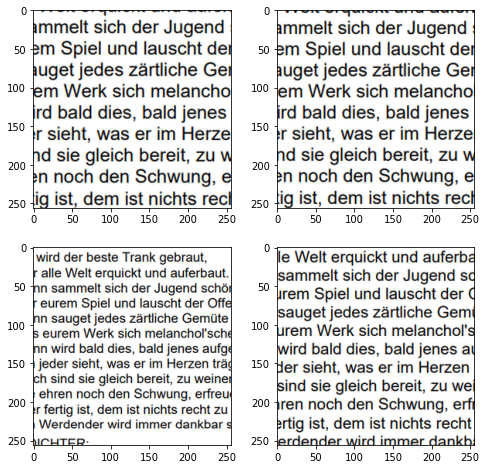

In [ ]:
n_smpl=2
scaled_imgs=[get_random_scaled_img('ML3/de/%d_%d.jpg'%(1, 1)) for i in range(n_smpl**2)]
fig, ax = plt.subplots(n_smpl, n_smpl, figsize=(n_smpl*4, n_smpl*4))
for row in range(n_smpl):
    for col in range(n_smpl):
        ax[col, row].imshow(scaled_imgs[row*n_smpl+col])
        ax[col, row].grid(False)

Read again images, now generating 5 rescaled from each one.

In [ ]:
labels0 = []
images0 = []
labels1 = []
images1 = []

mult = 5
#German
for book in range(1,6):
    for sample in range(1,11):
        for itr in range(mult):
            img = get_random_scaled_img('ML3/de/%d_%d.jpg'%(book, sample))
            assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
            images0.append(prepare_training_img(img))
            labels0.append([1,0])
#Italian
for book in range(1,6):
    for sample in range(1,11):
        for itr in range(mult):
            img = get_random_scaled_img('ML3/it/%d_%d.jpg'%(book, sample))
            assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
            images1.append(prepare_training_img(img))
            labels1.append([0,1])
        
idx = np.random.permutation(len(labels0))
labels0 = np.array(labels0)[idx]
images0 = np.array(images0)[idx]
labels1 = np.array(labels1)[idx]
images1 = np.array(images1)[idx]

In [ ]:
#We will take 80% from each for training and 20 for validation
n_half = images0.shape[0]
n_train_half = n_half*80//100
n_train = n_train_half*2

x_train = np.concatenate([images0[:n_train_half], images1[:n_train_half]])
y_train = np.concatenate([labels0[:n_train_half], labels1[:n_train_half]])

x_valid = np.concatenate([images0[n_train_half:], images1[n_train_half:]])
y_valid = np.concatenate([labels0[n_train_half:], labels1[n_train_half:]])

And finally do training again, same way. Just now we change the number of epochs: before we had 150, but now that we have 5 times more training data we'll do 60. While 60 > 150/5, it looks like it takes a bit more time to converge.
We use the same graph as before, `g2`, the one we can train.

In [ ]:
#We will take 80% from each for training and 20 for validation
n_half = images0.shape[0]
n_train_half = n_half*80//100
n_train = n_train_half*2

x_train = np.concatenate([images0[:n_train_half], images1[:n_train_half]])
y_train = np.concatenate([labels0[:n_train_half], labels1[:n_train_half]])

x_valid = np.concatenate([images0[n_train_half:], images1[n_train_half:]])
y_valid = np.concatenate([labels0[n_train_half:], labels1[n_train_half:]])

better version of augmentation:

In [ ]:
np.random.seed(42)  # ensure all groups and runs to have the same training/validation split.

# list all samples
de_book_sample = [(book, sample) for book in range(1,6) for sample in range(1,11)]
it_book_sample = [(book, sample) for book in range(1,6) for sample in range(1,11)]

de_book_sample = np.array(de_book_sample)
it_book_sample = np.array(it_book_sample)

# get array of permultation indexes
n_half = len(de_book_sample)  # size of both datasets is identical
de_idx = np.random.permutation(n_half)
it_idx = np.random.permutation(n_half)

# shuffle list of samples
de_book_sample = de_book_sample[de_idx]
it_book_sample = it_book_sample[it_idx]

# split training and validation
# We will take 80% from each for training and 20 for validation
n_train_half = n_half*80//100
n_train = n_train_half*2

de_book_sample_train = de_book_sample[:n_train_half] # first 80 %
de_book_sample_valid = de_book_sample[n_train_half:] # remaining part

it_book_sample_train = it_book_sample[:n_train_half] # first 80 %
it_book_sample_valid = it_book_sample[n_train_half:] # remaining part

x_train = []
y_train = []

x_valid = []
y_valid = []

mult = 10
for itr in range(mult):
    # each pair [book,sample] goes to either training or validation set, not both
    # German training
    for book, sample in de_book_sample_train:
        img = get_random_scaled_img('ML3/de/%d_%d.jpg'%(book, sample), scalemax=1.5)
        assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
        x_train.append(prepare_training_img(img))
        y_train.append([1,0])
  
    # Italian training
    for book, sample in it_book_sample_train:
        img = get_random_scaled_img('ML3/it/%d_%d.jpg'%(book, sample), scalemax=1.5)
        assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
        x_train.append(prepare_training_img(img))
        y_train.append([0,1])
  
    # German validation
    for book, sample in de_book_sample_valid:
        img = get_random_scaled_img('ML3/de/%d_%d.jpg'%(book, sample), scalemax=1.5)
        assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
        x_valid.append(prepare_training_img(img))
        y_valid.append([1,0])
  
    # Italian validation
    for book, sample in it_book_sample_valid:
        img = get_random_scaled_img('ML3/it/%d_%d.jpg'%(book, sample), scalemax=1.5)
        assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
        x_valid.append(prepare_training_img(img))
        y_valid.append([0,1])


x_train = np.array(x_train)
y_train = np.array(y_train)

x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

In [ ]:
x = tf.keras.layers.Input(shape=(256,256,3), dtype=tf.float32)

base_model.trainable = False
base_out = base_model(x)

base_out_f = tf.keras.layers.GlobalAveragePooling2D()(base_out)

h1 = tf.keras.layers.Dense(64, activation='sigmoid')(base_out_f)
h2 = tf.keras.layers.Dense(2, activation='softmax')(h1)

model_aug = tf.keras.Model(x, h2)

model_aug.compile(optimizer=tf.keras.optimizers.Adam(0.0005,) ,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
save_path = 'save/text_augmented_{epoch}.ckpt'

batch_size=10
n_itr_per_epoch = len(x_train) // batch_size
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                   save_weights_only=True,
                                                   save_freq=1 * n_itr_per_epoch) # save every 1 epochs
                                                   
hist = model_aug.fit(x_train, y_train,
                 epochs=40, batch_size=batch_size, 
                 validation_data=(x_valid, y_valid),
                 callbacks=[save_callback])

Epoch 1/40
80/80 [==============================] - 15s 129ms/step - loss: 0.6594 - accuracy: 0.6237 - val_loss: 0.6017 - val_accuracy: 0.6400
Epoch 2/40
80/80 [==============================] - 8s 105ms/step - loss: 0.5594 - accuracy: 0.7063 - val_loss: 0.5388 - val_accuracy: 0.7400
Epoch 3/40
80/80 [==============================] - 8s 106ms/step - loss: 0.5168 - accuracy: 0.7400 - val_loss: 0.5018 - val_accuracy: 0.7600
Epoch 4/40
80/80 [==============================] - 12s 149ms/step - loss: 0.4561 - accuracy: 0.7950 - val_loss: 0.4858 - val_accuracy: 0.7650
Epoch 5/40
80/80 [==============================] - 10s 120ms/step - loss: 0.4227 - accuracy: 0.8275 - val_loss: 0.4168 - val_accuracy: 0.8250
Epoch 6/40
80/80 [==============================] - 8s 105ms/step - loss: 0.3828 - accuracy: 0.8400 - val_loss: 0.3973 - val_accuracy: 0.8450
Epoch 7/40
80/80 [==============================] - 8s 106ms/step - loss: 0.3486 - accuracy: 0.8612 - val_loss: 0.3988 - val_accuracy: 0.8400
Epo

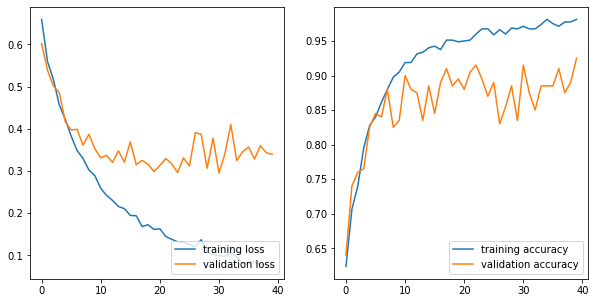

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

In [ ]:
# model_aug.load_weights('save/text_augmented_23.ckpt')
tf.saved_model.save(model_aug, "inference_model_aug/")

We had a REEEALLY small dataset for such a complicated task. Does it really generalize? mb it just memorizes all the images we fed into it? Lets perform a test. `w1.PNG` and `w2.PNG` are text screenshots from wikipedia in [Italian](https://it.wikipedia.org/wiki/Apprendimento_automatico) and [German](https://de.wikipedia.org/wiki/Maschinelles_Lernen).

In [ ]:
# load images
im_wiki_1 = plt.imread('ML3/w1.jpg')
im_wiki_2 = plt.imread('ML3/w2.jpg')

# crop/covert for proper color range
im_wiki_1_p = prepare_training_img(im_wiki_1)[np.newaxis]
im_wiki_2_p = prepare_training_img(im_wiki_2)[np.newaxis]

In [ ]:
output_name = model_aug.output_names[0]
inf = Inferer('inference_model_aug', output_name)

probabilities for w1: 0.9999999 detected language: italian
probabilities for w2: 0.99989676 detected language: italian


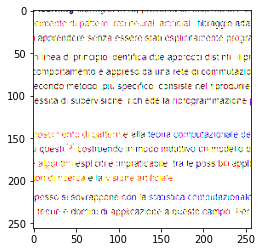

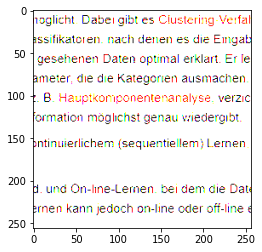

In [ ]:
class_name, prob = inf.infere(np.concatenate([im_wiki_1_p, im_wiki_2_p]), prob=True)


print('probabilities for w1:', prob[0], 'detected language:', class_name[0])
print('probabilities for w2:', prob[1], 'detected language:', class_name[1])

# Show image crops
plt.imshow( training_img_to_display(im_wiki_1_p[0]))
plt.show()
plt.imshow( training_img_to_display(im_wiki_2_p[0]))
plt.show()



## 9. Excercises

Do in 4 groups (35 min), in the end present results (2 min/group)

### Option 1.

There is a serious problem in the example above: the training and validation datasets are not independent. We generated 5 randomly scaled images from each initial image. With high probability from 5 images (generated from same initial one!) some will end up im the training and some in validation datasets. Since they are generated from the same initial ones, they are not fully independent. This compromises evaluation of model performance, leading to an overestimate of the performance.

1. Modify the generation of the training and validation datasets to fulfil requirenment of independance.
2. Check how validation accuracy and loss changes

Do not look solution to Option 1 ^_^

### Option 2.

In the situation when the model is likely to overfit, final performance would especially depend on the learning rate.

* Plot the best validation accuracy vs learning rate.
* Plot the number of epochs untill the best validation accuracy vs learning rate.

Test learning rates within +/- 1.5 orders of magnitude, i.e. from 30 times smaller to 30 times larger learning rates, than the current one.

Get 3 replicates.

Use test/validation split from solution to Exercise 1.

### Option 3.

In the situation when the model is likely to overfit, final performance would especially depend on the model's architecture.

* Plot the best validation accuracy vs width of the first dense layer.
* Plot the number of epochs untill the best validation accuracy vs width.

Test number of features in the first dense layer between 8 and 4096.

Get 3 replicates.

Use test/validation split from solution to Exercise 1.

### Option 4.

We tested one model for the backbone of trnasfer learning. Try other ones (at least 3): https://www.tensorflow.org/api_docs/python/tf/keras/applications.


* Plot the best validation accuracy vs model.
* Plot the number of epochs until the best validation accuracy vs model.
* Does any model generalize to wiki data?

Run 3 replicates for each model. Input size might vary for different models, adjust the crop size accordingly in parameters to `prepare_training_img`.

Use test/validation split from solution to Exercise 1.


In [ ]:
base_model = tf.keras.applications.resnet.ResNet101(include_top=False)

In [ ]:
def prepare_training_img(img, crop=True, resize=True, img_size=(256, 256)):
    if img.dtype != np.uint8:
        img *= 255.0

    if crop:
        crop = np.min(img.shape[:2])
        r = (img.shape[0] - crop) // 2
        c = (img.shape[1] - crop) // 2
        cropped = img[r: r + crop, c: c + crop]
    else:
        cropped = img

    if resize:
        img_pil = Image.fromarray(cropped)
        img_pil = img_pil.resize(img_size, Image.ANTIALIAS)
        resized = np.array(img_pil.convert('RGB'))
    else:
        resized = cropped.copy()

    if resized.ndim == 2:
        resized = resized[..., np.newaxis]
    if resized.shape[2] == 4:
        resized = resized[..., :3]
    if resized.shape[2] == 1:
        resized = np.concatenate((resized, resized, resized), axis=2)

    resized = resized.astype(np.float32)

    img_preproc = tf.keras.applications.resnet.preprocess_input(resized)
    # subtract imagenet mean
    return img_preproc

def training_img_to_display(img):
  return (img+1)/2

In [ ]:
x = tf.keras.layers.Input(shape=(256,256,3), dtype=tf.float32)

base_model.trainable = False
base_out = base_model(x)

base_out_f = tf.keras.layers.GlobalAveragePooling2D()(base_out)

h1 = tf.keras.layers.Dense(64, activation='sigmoid')(base_out_f)
h2 = tf.keras.layers.Dense(2, activation='softmax')(h1)

model_aug = tf.keras.Model(x, h2)

model_aug.compile(optimizer=tf.keras.optimizers.Adam(0.0005,) ,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_aug.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 resnet101 (Functional)      (None, None, None, 2048)  42658176  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 64)                131136    
                                                                 
 dense_15 (Dense)            (None, 2)                 130       
                                                                 
Total params: 42,789,442
Trainable params: 131,266
Non-trainable params: 42,658,176
_________________________________________

## 10. Homework


For more information on transfer learing look https://www.tensorflow.org/guide/keras/transfer_learning

So far we scaled images as a whole.
Which other augmentations would make sence for the text data?
Check https://www.tensorflow.org/tutorials/images/data_augmentation

## 11. Solutions

### Option 1

To prevent same rescaled versions of the same image ending up in both training and validation sets, we could split the dataset first

In [ ]:
np.random.seed(42)  # ensure all groups and runs to have the same training/validation split.

# list all samples
de_book_sample = [(book, sample) for book in range(1,6) for sample in range(1,11)]
it_book_sample = [(book, sample) for book in range(1,6) for sample in range(1,11)]

de_book_sample = np.array(de_book_sample)
it_book_sample = np.array(it_book_sample)

# get array of permultation indexes
n_half = len(de_book_sample)  # size of both datasets is identical
de_idx = np.random.permutation(n_half)
it_idx = np.random.permutation(n_half)

# shuffle list of samples
de_book_sample = de_book_sample[de_idx]
it_book_sample = it_book_sample[it_idx]

# split training and validation
# We will take 80% from each for training and 20 for validation
n_train_half = n_half*80//100
n_train = n_train_half*2

de_book_sample_train = de_book_sample[:n_train_half] # first 80 %
de_book_sample_valid = de_book_sample[n_train_half:] # remaining part

it_book_sample_train = it_book_sample[:n_train_half] # first 80 %
it_book_sample_valid = it_book_sample[n_train_half:] # remaining part

x_train = []
y_train = []

x_valid = []
y_valid = []

mult = 10
for itr in range(mult):
    # each pair [book,sample] goes to either training or validation set, not both
    # German training
    for book, sample in de_book_sample_train:
        img = get_random_scaled_img('ML3/de/%d_%d.jpg'%(book, sample), scalemax=1.5)
        assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
        x_train.append(prepare_training_img(img))
        y_train.append([1,0])
  
    # Italian training
    for book, sample in it_book_sample_train:
        img = get_random_scaled_img('ML3/it/%d_%d.jpg'%(book, sample), scalemax=1.5)
        assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
        x_train.append(prepare_training_img(img))
        y_train.append([0,1])
  
    # German validation
    for book, sample in de_book_sample_valid:
        img = get_random_scaled_img('ML3/de/%d_%d.jpg'%(book, sample), scalemax=1.5)
        assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
        x_valid.append(prepare_training_img(img))
        y_valid.append([1,0])
  
    # Italian validation
    for book, sample in it_book_sample_valid:
        img = get_random_scaled_img('ML3/it/%d_%d.jpg'%(book, sample), scalemax=1.5)
        assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
        x_valid.append(prepare_training_img(img))
        y_valid.append([0,1])


x_train = np.array(x_train)
y_train = np.array(y_train)

x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

for all practical problems: run several variations and plot them together (e.g. accuracy as outcome), and then